In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const
from numpy import random as ran
%matplotlib notebook

# the same routine as stack.py

In [2]:
z_bin = ([2.25,2.75])


path_16 = "/Users/jsmonzon/IGM/Spectra/2016/"

path_17 = "/Users/jsmonzon/IGM/Spectra/2017/"

spec_atr_16 = Table.read(path_16 + "spec_atr.txt", format='ascii')

spec_atr_17 = Table.read(path_17 + "spec_atr.txt", format='ascii')

    # read in

spec_16 = []

z_16 = []

coord_16 = []

for entry in spec_atr_16:  # from the CLAMATO 2016 survey

    if np.min(z_bin) < entry["zspec"] < np.max(z_bin):  # creating the bin size

        if entry["Conf"] < 10.0:  # excluding any QSOs

            temp = XSpectrum1D.from_file(path_16 + entry["Filename"])

            if temp.wvmin < (1216 * u.AA) * (1 + entry["zspec"]) < temp.wvmax:

                coord_16.append([entry["RA"], entry["Dec"]])  # coordinates in deg

                z_16.append(entry["zspec"])

                spec_16.append(XSpectrum1D.from_file(path_16 + entry["Filename"]))

spec_17 = []

z_17 = []

coord_17 = []

for entry in spec_atr_17:

    if np.min(z_bin) < entry["col5"] < np.max(z_bin):

        if entry["col4"] < 10.0:

            temp = XSpectrum1D.from_file(path_17 + entry["col1"])

            if temp.wvmin < (1120 * u.AA) * (1 + entry["col5"]) < temp.wvmax:

                coord_17.append([entry["col7"], entry["col8"]])  # coordinates in deg

                z_17.append(entry["col5"])

                spec_17.append(XSpectrum1D.from_file(path_17 + entry["col1"]))

/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [3]:
spec = np.asarray(spec_16 + spec_17)

print("Number of spectra =", len(spec))

red = np.asarray(z_16 + z_17)

coord = np.asarray(coord_16 + coord_17)

Number of spectra = 401


In [6]:
def cut_sample(spec, red, coord, thres, s2n):
    
    """
    :param spec: [array] of XSpectrum1D objects: use clamato_read.py
    :param red: [array] of their redshift values (z)
    :param coord: [array] of coordinates
    :param thres: [int] value for the maximum std to include in the lyman limit cut
    :param s2n: [float] lowest value of S/N to include in the cut
    """

    print("Number of spectra in the 2.25 < z < 2.75 bin (full sample) =", len(spec))

    # First we exclude any galaxies with 'non-zero' fluxes past the lyman limit
    # by removing those that are past the sigma threshold

    r = range(len(spec))

    temp = [np.asarray(spec[i].wavelength / (1 + red[i])) for i in r]  # rest-frame

    lylim = [(entry < 912) for entry in temp] # a mask to select the values past 912A

    lylim_flux = np.asarray([spec[i].flux[lylim[i]] for i in r])
    
    lylim_med = np.asarray([np.median(i) for i in lylim_flux])
    
    lylim_dist = lylim_med[~np.isnan(lylim_med)]
    
    mean = np.mean(lylim_dist)
    
    std = np.std(lylim_dist)
    
    lylim_cut = [(i < (mean - (thres*std))) & ((mean + (thres*std)) < i) for i in lylim_dist]
        
    
    plt.figure(figsize=(10,10))
    plt.hist(lylim_dist, bins = 60,edgecolor='white', linewidth=1.2, label="160 Sample", color="grey")
    plt.vlines((mean - (thres*std)),0,100, linestyle="--", color="green", label = "1 $\sigma$")
    plt.vlines((mean + (thres*std)),0,100, linestyle="--", color="green")
    
    plt.vlines((mean - (thres*std*2)),0,80, linestyle="--", color="orange", label = "2 $\sigma$")
    plt.vlines((mean + (thres*std*2)),0,80, linestyle="--", color="orange")
    
    plt.vlines((mean - (thres*std*3)),0,60, linestyle="--", color="red", label = "3 $\sigma$")
    plt.vlines((mean + (thres*std*3)),0,60, linestyle="--", color="red")
    
    plt.vlines(mean,0,120, linestyle="--", color="black", label = "mean")
        
    
    plt.ylabel("# of Spectra",fontsize=15)
    plt.xlabel("Median flux values blueward of 912$\AA$",fontsize=15)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlim(-1,1)
    
    plt.show()
    

    
    
    

Number of spectra in the 2.25 < z < 2.75 bin (full sample) = 401


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


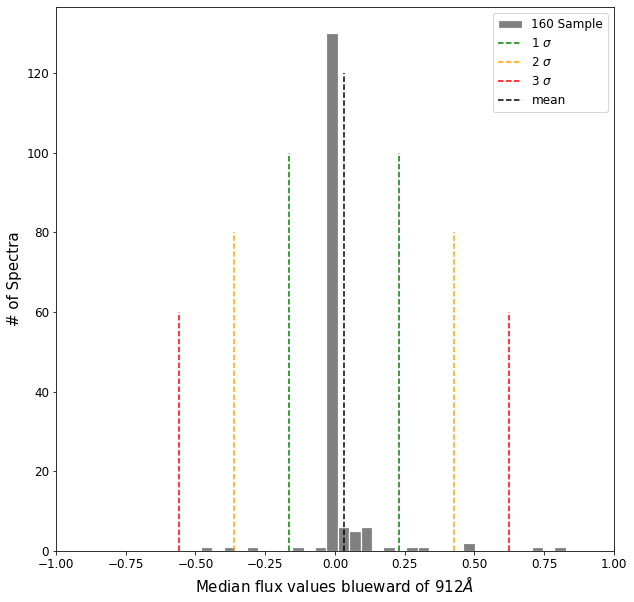

TypeError: cannot unpack non-iterable NoneType object

In [7]:
spec, red, coord = cut_sample(spec, red, coord, 1, 2.5)

In [ ]:
collate = ltsu.collate(t_spec)  # to get a single XSpec object

fix = []  # to make sure none of the values included will mess up the stack

a = collate.data['wave']

for i in range(collate.nspec):

    if np.min(a[i]) == 0.0:
        fix.append(i)

if len(fix) > 0:

    print("deleting these spectra", fix)

    good_spec = np.delete(t_spec,fix) # exclude all spec[fix]

    red = np.delete(red,fix)
    
print("Number of spectra to be stacked =", collate.nspec)

collate = ltsu.collate(good_spec)


In [ ]:
rest_spec = ltsu.rebin_to_rest(collate, red, 300 * u.km / u.s, grow_bad_sig=True)

In [ ]:
stack = ltsu.smash_spectra(rest_spec)

stack.plot()

# Example Spec

2.384


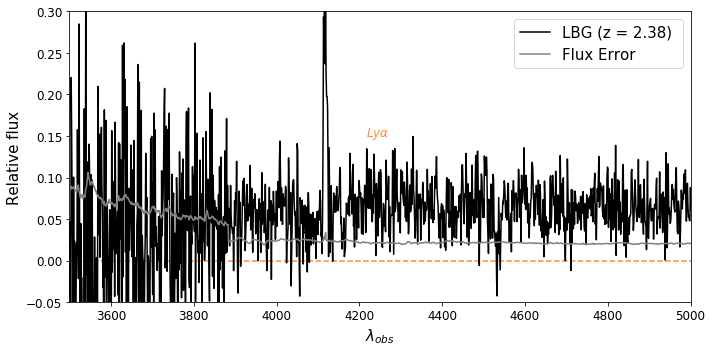

In [6]:
I = 7
print(red[I])
#23

plt.figure(figsize=(10, 5), tight_layout=True)

plt.plot(spec[I].wavelength,spec[I].flux,color="black",label="LBG (z = 2.38) ")
plt.plot(spec[I].wavelength,spec[I].sig, color="grey",label="Flux Error")

plt.hlines(0,3500,5000, color="#fd8d3c",linestyle="--")

plt.text(4215,.15,"$Lyα$",fontsize=12,color="#fd8d3c")

plt.xlabel("$\lambda_{obs}$",fontsize=15)
plt.ylabel("Relative flux",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(3500,5000)
plt.ylim(-.05,.3)

plt.savefig("/Users/jsmonzon/IGM/figures/exspec.pdf")


plt.show()

In [ ]:
plt.fill_between?

In [ ]:
spec[67].plot()

In [25]:
arr1 = np.linspace(0,14,12)

arr2 = np.linspace(14,123,22)

In [26]:
yaga = np.append(arr1,arr2)

In [27]:
yaga

array([  0.        ,   1.27272727,   2.54545455,   3.81818182,
         5.09090909,   6.36363636,   7.63636364,   8.90909091,
        10.18181818,  11.45454545,  12.72727273,  14.        ,
        14.        ,  19.19047619,  24.38095238,  29.57142857,
        34.76190476,  39.95238095,  45.14285714,  50.33333333,
        55.52380952,  60.71428571,  65.9047619 ,  71.0952381 ,
        76.28571429,  81.47619048,  86.66666667,  91.85714286,
        97.04761905, 102.23809524, 107.42857143, 112.61904762,
       117.80952381, 123.        ])

In [18]:
arr1

array([ 0.        ,  0.28571429,  0.57142857,  0.85714286,  1.14285714,
        1.42857143,  1.71428571,  2.        ,  2.28571429,  2.57142857,
        2.85714286,  3.14285714,  3.42857143,  3.71428571,  4.        ,
        4.28571429,  4.57142857,  4.85714286,  5.14285714,  5.42857143,
        5.71428571,  6.        ,  6.28571429,  6.57142857,  6.85714286,
        7.14285714,  7.42857143,  7.71428571,  8.        ,  8.28571429,
        8.57142857,  8.85714286,  9.14285714,  9.42857143,  9.71428571,
       10.        , 10.28571429, 10.57142857, 10.85714286, 11.14285714,
       11.42857143, 11.71428571, 12.        , 12.28571429, 12.57142857,
       12.85714286, 13.14285714, 13.42857143, 13.71428571, 14.        ])

In [19]:
arr2

array([ 14.        ,  16.2244898 ,  18.44897959,  20.67346939,
        22.89795918,  25.12244898,  27.34693878,  29.57142857,
        31.79591837,  34.02040816,  36.24489796,  38.46938776,
        40.69387755,  42.91836735,  45.14285714,  47.36734694,
        49.59183673,  51.81632653,  54.04081633,  56.26530612,
        58.48979592,  60.71428571,  62.93877551,  65.16326531,
        67.3877551 ,  69.6122449 ,  71.83673469,  74.06122449,
        76.28571429,  78.51020408,  80.73469388,  82.95918367,
        85.18367347,  87.40816327,  89.63265306,  91.85714286,
        94.08163265,  96.30612245,  98.53061224, 100.75510204,
       102.97959184, 105.20408163, 107.42857143, 109.65306122,
       111.87755102, 114.10204082, 116.32653061, 118.55102041,
       120.7755102 , 123.        ])